**Лабораторная работа  №3**

Белов Владимир Станиславович ББМО-01-23

**Задачи:**
1. Внимание в СНС VGG (карта значимости признаков и grad-CAM)

  a. Использовать репозиторий https://github.com/raghakot/kerasvis/blob/master/examples/vggnet/attention.ipynb

  b. Чтобы визуализировать активацию на конечных выходах плотного
слоя, необходимо переключить активацию softmax на линейную,
поскольку градиент выходного узла будет зависеть от всех активаций
других узлов. Сделать это в keras сложно, поэтому необходимо применить
utils.apply_modifications для изменения параметров сети и перестройки
графика. Если эта замена не будет выполнена, результаты могут быть
неоптимальными. Мы начнем с замены "softmax" на "linear".

  c. Загрузить 4 различных изображения из датасета ImageNet и
отобразить их на одном графике c помощью команды:
(img1 = utils.load_img('***.jpg/png', target_size=(224, 224)))

  d. Отобразить карты значимости признаков, найти и задать верный
параметр filter_indices, отображающий класс изображения ImageNet.

  e. Оценить полученный результат на прошлом этапе и отображение
признаков с помощью управляемой значимости.

2. gradCAM - ванильный, управляемый, ректифицированный. Они должны
содержать больше деталей, поскольку в них используются объекты Conv
или объединения, которые содержат больше пространственных деталей,
которые теряются в плотных слоях.

Загрузим необходимые библиотеки

In [1]:
!pip install tf-keras-vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 2.2 MB/s eta 0:00:00


In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import tensorflow as tf
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16 as Model

Загрузим 4 различных изображения из датасета ImageNet и
отобразим их

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


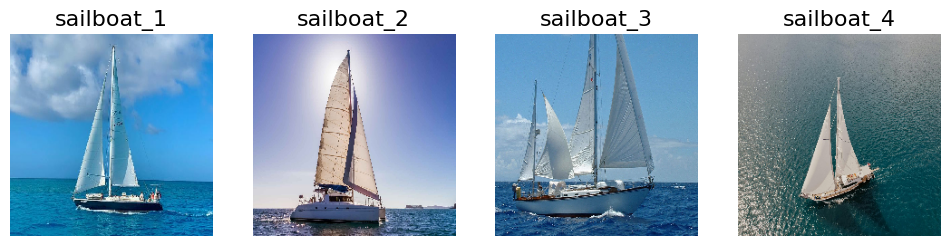

In [3]:
model = Model(weights='imagenet', include_top=True)

img1 = load_img('sailboat_1.jpg', target_size=(224, 224))
img2 = load_img('sailboat_2.jpg', target_size=(224, 224))
img3 = load_img('sailboat_3.jpg', target_size=(224, 224))
img4 = load_img('sailboat_4.jpg', target_size=(224, 224))

# Преобразуем в массив NumPy и нормализуем
imagesArr = np.asarray([np.array(img1), np.array(img2), np.array(img3), np.array(img4)])
X = preprocess_input(imagesArr)

imagesTitles = ['sailboat_1', 'sailboat_2', 'sailboat_3', 'sailboat_4'] # Список заголовков изображений
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(imagesTitles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(imagesArr[i])
    ax[i].axis('off')

Чтобы визуализировать активацию на конечных выходах плотного
слоя, необходимо переключить активацию softmax на линейную. Вычислим карты значимости методом Saliency

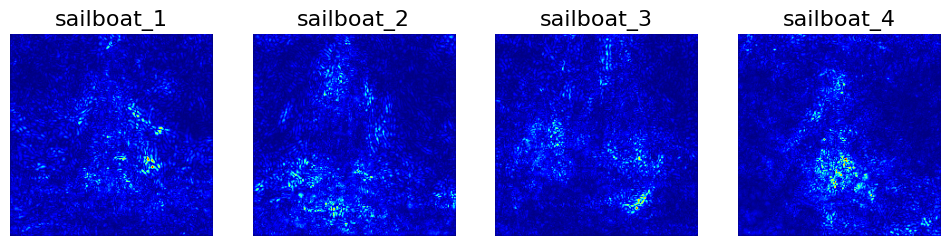

In [29]:
# Создаем экземпляр класса ReplaceToLinear
replace2linear = ReplaceToLinear()

# Определяем функцию модификации модели
def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear

# Создаем объект CategoricalScore с заданными индексами классов
score = CategoricalScore([857, 330, 784, 900])
def score_function(output):
    return (output[0][857], output[1][330], output[2][784], output[3][900])

saliency = Saliency(model, model_modifier=replace2linear, clone=True)
mapList = saliency(score, X)

for i, title in enumerate(imagesTitles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(mapList[i], cmap='jet')  # Выводим с помощью цветовой карты jet чтобы понять какие части вносят больший вклад в принятие решения
    ax[i].axis('off')


Вычисляем карты значимости с использованием параметров сглаживания SmoothGrad


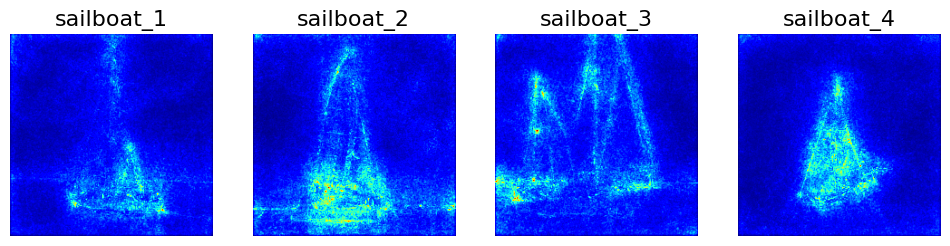

In [30]:
mapList = saliency(score, X, smooth_samples=20, smooth_noise=0.20)

f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(imagesTitles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(mapList[i], cmap='jet')
    ax[i].axis('off')

Выполним построение карт значимости классов с помощью метода gradCAM

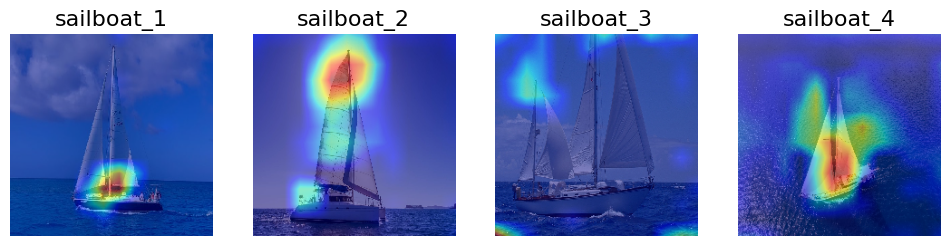

In [41]:
gradcam = Gradcam(model, model_modifier=replace2linear, clone=True)
mapList = gradcam(score, X, penultimate_layer=-1)

f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(imagesTitles):
    mapList2 = np.uint8(cm.jet(mapList[i])[..., :4] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(imagesArr[i])  # Оригинальное изображение
    ax[i].imshow(mapList2, cmap='jet', alpha=0.5)  # Карта с прозрачностью
    ax[i].axis('off')

Выполним построение карт значимости классов с помощью улучшенного метода gradCAM++

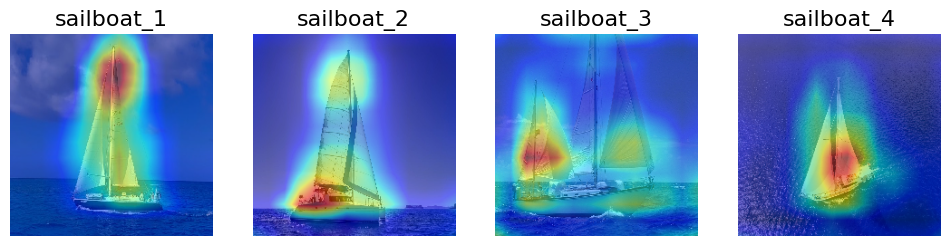

In [40]:
gradcam = GradcamPlusPlus(model, model_modifier=replace2linear, clone=True)
mapList = gradcam(score, X, penultimate_layer=-1)

f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(imagesTitles):
    mapList2 = np.uint8(cm.jet(mapList[i])[..., :4] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(imagesArr[i])
    ax[i].imshow(mapList2, cmap='jet', alpha=0.5)
    ax[i].axis('off')

**Вывод**

В ходе работы мы использовали методы визуализации Saliency, SmoothGrad, Grad-CAM, Grad-CAM++.  

Метод SmoothGrad значительно снижает шум и карта четко различима, в отличии от метода Saliency. Grad-CAM++ лучше распознал объекты на изображении и в большем объеме отобразил на карте, чем метод Grad-CAM.